# Multivariate Linear Regression

## Introduction

We will implement the _multivariate linear regression_ which we just call the _linear regression_. It is a model with two or more predictors and one response variable (opposed to one predictor using the simple linear regression).

## Requirements
### Knowledge

You should have a basic knowledge of:
- Univariate lineare regression
- Multivariate linear regression
- Squared error
- Gradient descent
- numpy
- matplotlib

Suitable sources for acquiring this knowledge are:
- [Multivariate Linear Regression Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/multivariate_linear_regression.php) by Christian Herta and his [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/multivariateLinearRegression.pdf) (German)
- Chapter 2 of the open classroom [Machine Learning](http://openclassroom.stanford.edu/MainFolder/CoursePage.php?course=MachineLearning) by Andrew Ng
- Chapter 5.1 of [Deep Learning](http://www.deeplearningbook.org/contents/ml.html) by Ian Goodfellow 
- Some parts of chapter 1 and 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop
- [numpy quickstart](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [Matplotlib tutorials](https://matplotlib.org/tutorials/index.html)

### Python Modules

By [deep.TEACHING](https://www.deep-teaching.org/) convention, all python modules needed to run the notebook are loaded centrally at the beginning. 


In [1]:
# External Modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from tqdm import tqdm

%matplotlib notebook

### Create Dataset
First we will create some features. The features should be in a 2D numpy array, the rows seperating the different feature vectors, the columns containing the features. Each feature should be uniformly distributed in a specifiable range. Afterward we use the features to create the labels. Since each of the images have to be on a plane, we just use a linear hypothesis and add some gaussian noise to make the dataset more realistic.

In [2]:
def create_feature_matrix(sample_size, n_features, x_min, x_max, sigma):
    '''creates random feature vectors based on a lienar function in a given interval
    
    Args:
        sample_size: number feature vectors
        n_features: number of features for each vector
        x_min: lower bound value ranges
        x_max: upper bound value ranges
    
    Returns:
        x: 2D array containing feature vecotrs with shape (sample_size, n_features)
        y: 
    '''
    x = np.random.uniform(x_min, x_max, (sample_size, n_features))
    theta = np.random.randn(x.shape[1], 1)
    h = np.dot(x, theta)
    y = np.random.normal(h, sigma)
    return x, y

In [3]:
sample_size = 100
n_features = 2
x_min = [-4,-3]
x_max = [11.,5.0]
sigma = 3

x, y = create_feature_matrix(sample_size, n_features, x_min, x_max, 2)
print(x.shape, y.shape)

(100, 2) (100, 1)


### Plot The Data

To get a visualization we plot the data $D = \{(x^{(1)}_1,x^{(1)}_2,y^{(1)}), \ldots, (x^{(n)}_1,x^{(n)}_2,y^{(n)})\}$ in a 3D scatter plot.

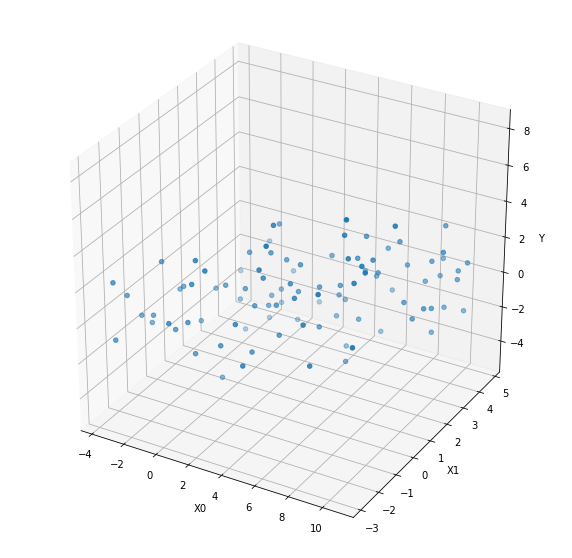

In [4]:
def plot_data_scatter(features, targets):
    """ Plots the features and the targets in a 3D scatter plot
    
    Args:
        features: 2D numpy-array features
        targets: ltargets
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features.T[0], features.T[1], targets)
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_zlabel('Y')
    plt.show
    
plot_data_scatter(x, y)

### Create Placeholder

After creating our features, we can create the placeholders based on the features - both have to have the same shape.

In [5]:
X_ = tf.placeholder(tf.float32, shape=x.shape)
Y_ = tf.placeholder(tf.float32, shape=y.shape)

## Multivariate Linear Regression

### Linear Hypothesis
A short recap, a hypothesis $h_\theta(x)$ is a certain function that we believe is similar to a target function that we like to model. A hypothesis $h_\theta(x)$ is a function of $x$ with fixed parameters $\theta$. 

Here we have $n$ features $x = [x_1, \ldots, x_n ]$ and $n+1$ $\theta$s:

$$
h_\theta(x) = \theta_{0} + \theta_{1} x_1 + \ldots \theta_n x_n 
$$

adding an extra element to $x$ for convenience, this could also be rewritten as:

$$
h_\theta(x) = \theta_{0} x_0 + \theta_{1} x_1 + \ldots \theta_n x_n 
$$

with $x_0 = 1$ for all feature vectors. Or treating $x$ and $\theta$ as vectors:


$$
h(\vec x) = \vec \theta^T \vec x'
$$

with:

$$
\vec x = \begin{pmatrix} 
x_1 & x_2 & \ldots & x_n \\
\end{pmatrix}
\text{   and   }
\vec x' = \begin{pmatrix} 
1 & x_1 & x_2 & \ldots & x_n \\
\end{pmatrix}
$$

Or for the whole data set at once:

$$
h(\vec x) = \vec \theta^T X'
$$

with:

$$
X = \begin{pmatrix} 
x_1^1 & \ldots & x_n^1 \\
x_1^2 & \ldots & x_n^2 \\
\vdots &\vdots &\vdots \\
x_1^m & \ldots & x_n^m \\
\end{pmatrix}
\text{   and   }
X' = \begin{pmatrix} 
1 & x_1^1 & \ldots & x_n^1 \\
1 & x_1^2 & \ldots & x_n^2 \\
\vdots &\vdots &\vdots &\vdots \\
1 & x_1^m & \ldots & x_n^m \\
\end{pmatrix}
$$

In [6]:
def linear_hypothesis(thetas):
    ''' Combines given list argument in a linear equation and returns it as a function

    Args:
        thetas: list of coefficients

    Returns:
        lambda that models a linear function based on thetas and x
    '''
    ones = tf.zeros([X_.shape.dims[0], 1])
    X_prime = tf.concat([ones, X_], 1)
    return tf.matmul(X_prime, thetas)

### Cost Function
A cost function $J$ depends on the given training data $D$ and hypothesis $h_\theta(x)$. In the context of the linear regression, the cost function measures how wrong a model is regarding its ability to estimate the relationship between $x$ and $y$ for specific $\theta$ values. Later we will treat this as an optimization problem and try to minimize the cost function $J_D(\theta)$ to find optimal $\theta$ values for our hypothesis $h_\theta(x)$. The cost function we use in this exercise is the [Mean-Squared-Error](https://en.wikipedia.org/wiki/Mean_squared_error) cost function:

\begin{equation}
    J_D(\theta)=\frac{1}{2m}\sum_{i=1}^{m}{(h_\theta(x_i)-y_i)^2}
\end{equation}

Implement the cost function $J_D(\theta)$ in the method `mse_cost_function`. The method should return a function that takes the values of $\theta_0$ and $\theta_1$ as an argument.

Sidenote, the terms loss function or error function are often used interchangeably in the field of Machine Learning.

In [7]:
def mse_cost_function(x, y, hypothesis):
    ''' Implements MSE cost function as a function J(theta) on given traning data 
    
    Args:
        x: vector of x values 
        y: vector of ground truth values y 
        
    Returns:
        lambda J(theta) that models the cost function
    '''
    return tf.reduce_mean(tf.pow(hypothesis - Y_, 2))

###  Gradient Descent

A short recap, the gradient descent algorithm is a first-order iterative optimization for finding a minimum of a function. From the current position in a (cost) function, the algorithm steps proportional to the negative of the gradient and repeats this until it reaches a local or global minimum and determines. Stepping proportional means that it does not go entirely in the direction of the negative gradient, but scaled by a fixed value $\alpha$ also called the learning rate. Implementing the following formalized update rule is the core of the optimization process:

\begin{equation}
    \theta_{j_{new}} \leftarrow \theta_{j_{old}} - \alpha * \frac{\delta}{\delta\theta_{j_{old}}} J(\theta_{old})
\end{equation}

In [8]:
def update_theta(x, y, theta, learning_rate, loss_function, sess):
    ''' Updates learnable parameters theta_0 and theta_1

    The update is done by calculating the partial derivities of
    the cost function including the linear hypothesis. The
    gradients scaled by a scalar are subtracted from the given
    theta values.

    Args:
        x: array of x values
        y: array of y values corresponding to x
        theta_0: current theta_0 value
        theta_1: current theta_1 value
        learning_rate: value to scale the negative gradient

    Returns:
        t: Updated theta
    '''
    grad = tf.gradients(loss_function, theta)
    t_grad = sess.run(grad, feed_dict={X_: x, Y_: y})
    t = theta - learning_rate * t_grad[0]
    return t

Using the `update_theta` method, you can now implement the gradient descent algorithm. Iterate over the update rule to find the values for $\theta$ that minimize our cost function $J_D(\theta)$. This process is often called training of a machine learning model. 

In [9]:
def gradient_descent(x, y, theta, iterations=1000, learning_rate=0.0001):
    ''' Minimize theta values of a linear model based on MSE cost function

    Args:
        x: vector, x values from the data set
        y: vector, y values from the data set
        iterations: scalar, number of theta updates
        learning_rate: scalar, scales the negative gradient 
        verbose: boolean, print addition information 

    Returns:
        t0: Updated theta_0
        t1: Updated theta_1
    '''
    loss_history = []
    # initialize session
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in tqdm(range(iterations)):
        # defining the forward path
        mse = mse_cost_function(x, y, linear_hypothesis(theta))
        # backpropagate - updating theta
        theta = update_theta(x, y, theta, learning_rate, mse, sess)
        # calculating the current loss and appending it to list
        loss = sess.run(mse, feed_dict={X_: x, Y_: y})
        loss_history.append(loss)
    return theta, loss_history, sess

In [10]:
theta = tf.reshape(tf.Variable([3, 5, -1], dtype=tf.float32), shape=(3, 1))
opt_theta, loss_history, sess = gradient_descent(x, y, theta, iterations=20, learning_rate=0.01)

100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


###  Model and Training Evaluation
Now visualize the training process by plotting the `cost_hist` as a curve. Also, create a plot that shows the decision boundary of your final hypothesis (model) inside your data. Your plots should look like:

In [11]:
def evaluation_plt(loss_history, opt_theta, x, y, sess):
    ''' Plots a cost curve and the decision boundary

    The Method plots a cost curve from a given training process (cost_hist). 
    It also plots the data set (x,y) and draws a linear decision boundary 
    with the parameters theta_0 and theta_1 into the plotted data set.

    Args:
        cost_hist: vector, history of all cost values from a opitmization
        theta_0: scalar, model parameter for boundary
        theta_1: scalar, model parameter for boundary
        x: vector, x values from the data set
        y: vector, y values from the data set
    '''
    theta = sess.run(opt_theta)
    y_fit = sess.run(linear_hypothesis(theta), feed_dict={X_:x})
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)
    ax.plot(loss_history)
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x.T[0], x.T[1], y)
    ax.plot_trisurf(x.T[0], x.T[1], y_fit.reshape(y_fit.shape[0]))
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_zlabel('Y')

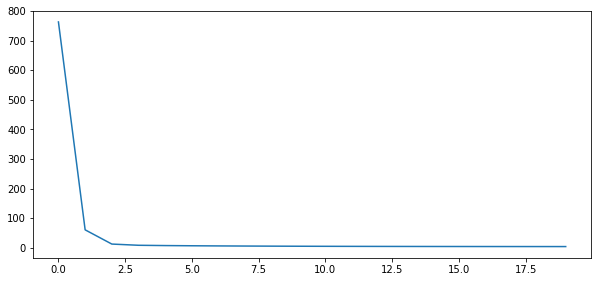

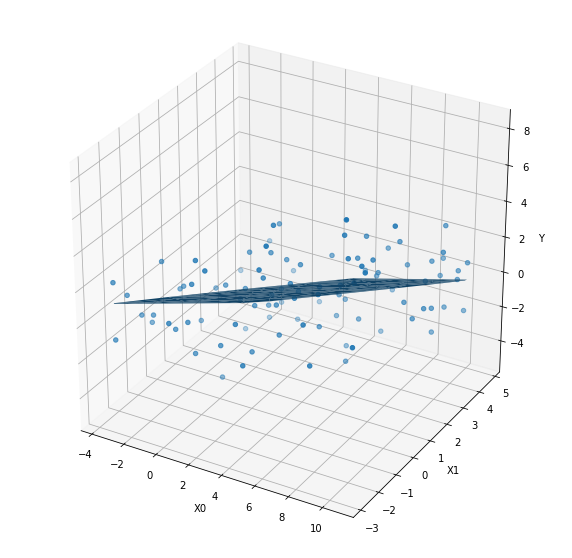

In [12]:
evaluation_plt(loss_history, opt_theta, x, y, sess)

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Simple Linear Regression <br/>
by Christian Herta, Benjamin Voigt <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Benjamin Voigt

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.